In [8]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    # print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    # !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    # import torch
    # import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.4.0+cu124
torchvision version: 0.19.0+cu124


In [9]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from torch import nn
from torchvision import transforms
from torchinfo import summary
from modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [11]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [12]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually - transforms to be applied to an image
manual_transforms = transforms.Compose([ #Composes several transforms together. 
    transforms.Resize((IMG_SIZE, IMG_SIZE)), #Resize the input image to the given size
    transforms.ToTensor(), #Convert a PIL Image or numpy.ndarray to tensor. torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
])
print(f"Manually created transforms: {manual_transforms}") #will be applied to dataset later

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [13]:
# Set the batch size
BATCH_SIZE = 16 # course suggested 32 but cuda ran out of memory, this is lower than the ViT paper but it's because we're starting small

# Create data loaders - dont pay much attention, we have our own for pcs
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1b260684e80>,
 ['pizza', 'steak', 'sushi'])

In [15]:
image_batch, label_batch = next(iter(train_dataloader)) # Get a batch 
image_batch.shape, label_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [16]:
image, label = image_batch[0], label_batch[0] # Get a single image from the batch

# View the batch shapes
image.shape, label #image shape is CxHxW

(torch.Size([3, 224, 224]), tensor(1))

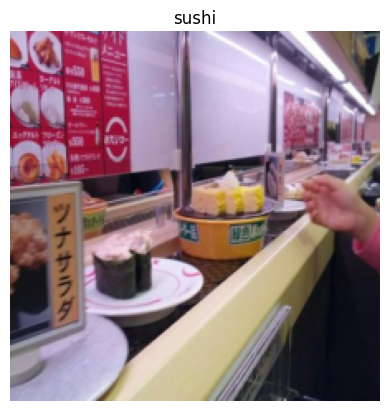

In [36]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

Overview of the architecture that needs to be implemented can be found here https://github.com/mrdbourke/pytorch-deep-learning/blob/main/08_pytorch_paper_replicating.ipynb. (Section 3.2.2 Look at colored arrows if there is a confusion)

In [37]:
#start making patch embeddings
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

number_of_patches = int((height * width) / patch_size**2)# Calculate N (number of patches)
print(f"Number of patches (N)): {number_of_patches}")

Number of patches (N)): 196


In [38]:
#most important thing to understand the embedding design
embedding_layer_input_shape = (height, width, color_channels) # Input shape (this is the size of a single image)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels) # Output shape - patch_size**2 bcz its is a sqaure patch

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


torch.Size([224, 224, 3])
extracted TOP ROW size torch.Size([16, 224, 3])
extracted PATCH size torch.Size([16, 16, 3])


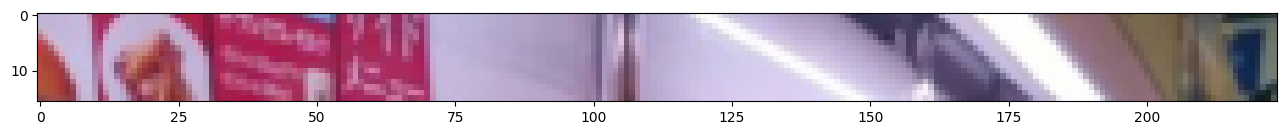

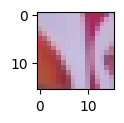

In [39]:
#visualization only, dont pay much attention
image_permuted = image.permute(1, 2, 0)
print(image_permuted.shape)
# Index to plot the TOP ROW of patched pixels - 16x224x3
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
print("extracted TOP ROW size", image_permuted[:patch_size, :, :].shape)
plt.imshow(image_permuted[:patch_size, :, :]);

plt.figure(figsize=(1, 1))
print("extracted PATCH size", image_permuted[:patch_size, :patch_size, :].shape)
plt.imshow(image_permuted[:patch_size, :patch_size, :]); #16, 16, 3

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


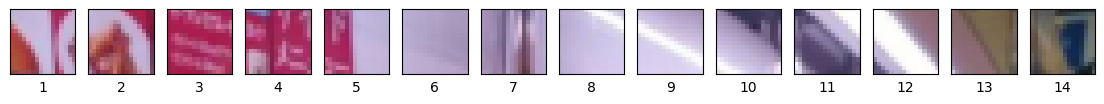

In [40]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
#visulatization only ignore
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


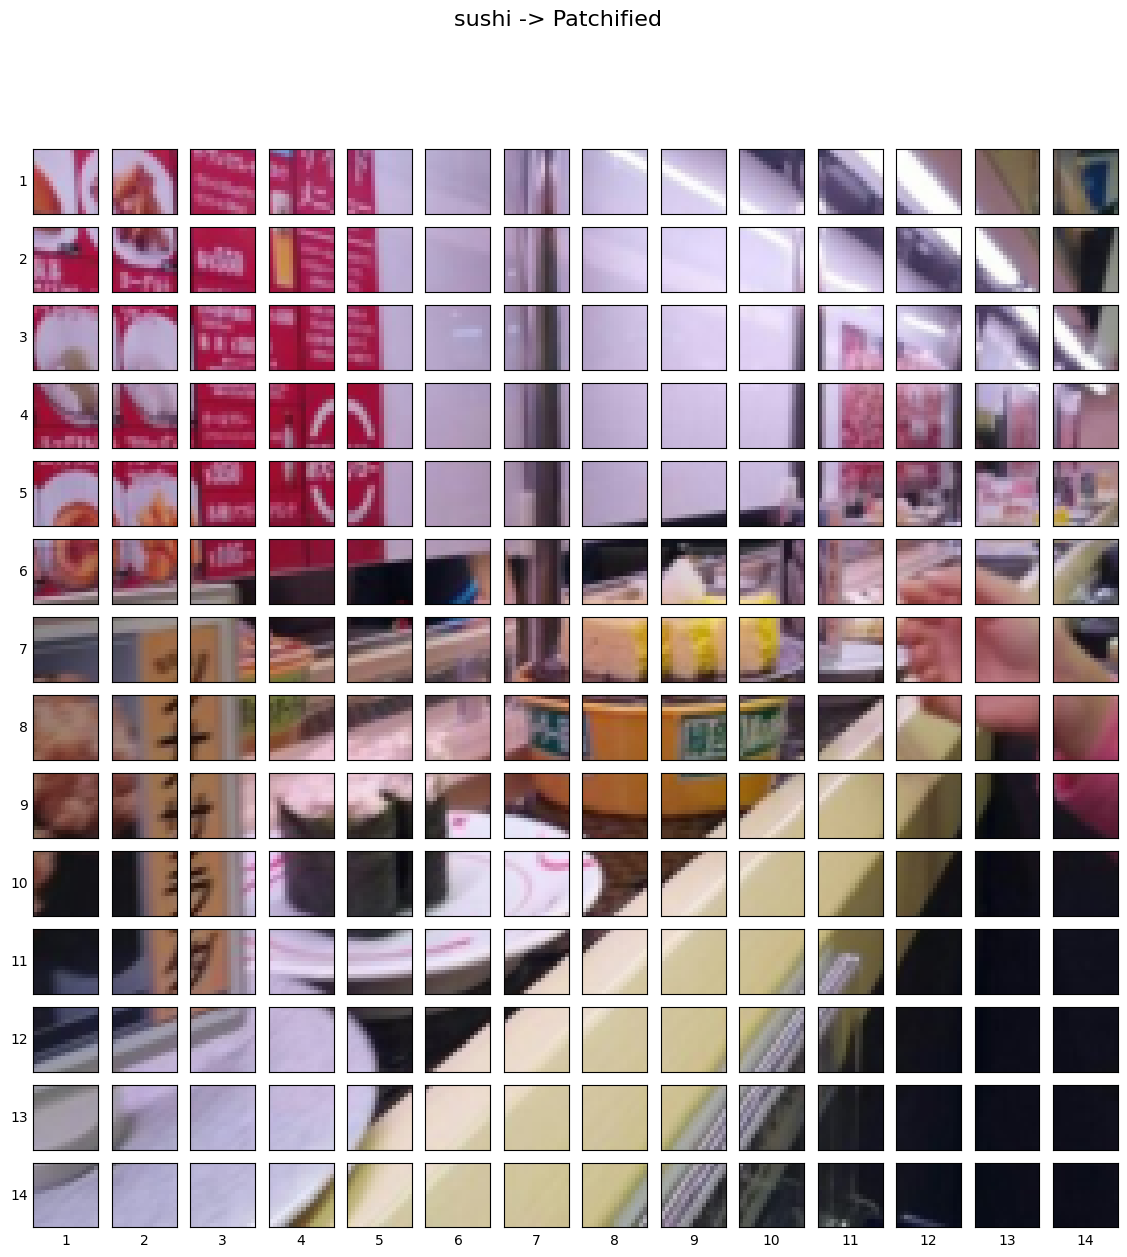

In [41]:
#visualization only ignore
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [42]:
# Input shape (single 2D image): (224, 224, 3), we need to get to output shape
# Output shape (single 2D image flattened into patches): (196, 768)
#see cells above
patch_size = 16

# Create the Conv2d layer with hyperparameters from the ViT paper
#input N(batch_size)xC(3)xH(224)xW(224) ->  output N(batch_size)xC(768)xH(14)xW(14) [H(224/16),W(224/16) calc from kernel_size and stride, by sliding on original image]

#lets break it down for what is happening in each kernel slide window(channels)
#kernel is 16x16, slides with stride 16, so each kernel with area 256 slides only once on a part of img with area 
#256, one to one correspondence betweeen these kernel area elements(in 2d) and image part(slide on top of each 
# other). now the image has 3 channels originally and kernel has 768 channels(768 weights). so imagine for each of 
# these 256 elements in the area of the image, a NN layer which converts from 3 to 768 channels by multiplyig each 
# element from 3 channels to all element from 768(weights), o/p is thus a 768 dim channel for each of these 256 
# elements. Now finally sum them up together (256 elements) to have a single 768 dim value for each area of size 
# 256. No relation to the fact that 256x3 is 768. We could blow up these 256 area to any dim we wanted(like 512) and
# then sum them up to get a 512 dim vector for each area.

conv2d = nn.Conv2d(in_channels=3, # number of input color channels
                   out_channels= 768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size, 
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [43]:
# Pass the image through the convolutional layer
print(image.shape) #rn only an image
batch_img = image.unsqueeze(0) 
print(batch_img.shape) #now the image in a batch(size =1 as only one image)
image_conv = conv2d(batch_img) 
print(image_conv.shape) #imagine like a smaller picture but with a 768 long channel depth

#[batch_size, embedding_dim, feature_map_height, feature_map_width]
m = nn.Flatten(2, 3)
print(m(image_conv).size()) #can also flatten with a nn module 
print(image_conv.requires_grad, image_conv.grad_fn, image_conv[:,0,:,:])#means gradients are tracked and updated automatically using gradient descent

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 768, 14, 14])
torch.Size([1, 768, 196])
True <ConvolutionBackward0 object at 0x0000023B1E6D4070> tensor([[[-0.7514, -0.7192, -0.6941, -0.5830, -0.7669, -0.7849, -0.6370,
          -1.0255, -0.8602, -0.3465, -0.7714, -0.7663, -0.4509, -0.5353],
         [-0.7718, -0.4269, -0.5213, -0.7431, -0.7426, -0.8149, -0.6226,
          -0.9852, -1.0433, -1.0379, -0.5894, -0.7536, -0.5621, -0.2547],
         [-0.7314, -0.6220, -0.8085, -0.6059, -0.7405, -0.7501, -0.4862,
          -0.9253, -1.0307, -0.9163, -1.1725, -0.8112, -0.7098, -0.5575],
         [-0.6742, -0.7452, -0.6523, -0.5399, -0.7212, -0.7909, -0.4347,
          -0.9064, -0.9685, -0.7883, -0.8457, -0.7096, -0.9471, -0.7816],
         [-0.5545, -0.5765, -0.7253, -0.6310, -0.6789, -0.7753, -0.4047,
          -0.8843, -0.8549, -0.7137, -0.7389, -0.4573, -0.5307, -0.7308],
         [-0.5681, -0.6295, -0.4697, -0.3148, -0.4461, -0.8620, -0.2561,
          -0.3870, -0.338

Showing random convolutional feature maps from indexes: [722, 512, 623, 663, 603]


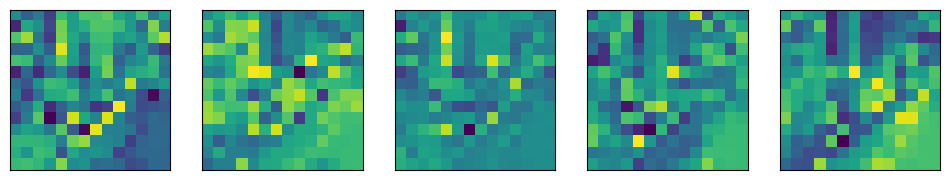

In [44]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    #displays a 14x14 image and uses one of the idx from the 758 embedding dims for color
    image_conv_feature_map = image_conv[:, idx, :, :] #torch.Size([1(batch), 14(h), 14(w)]) #only one channel for color, given by value
    # print(image_conv_feature_map.shape)
    image_conv_feature_map = image_conv_feature_map.squeeze() #remove the batch dim now 14x14
    image_conv_feature_map =  image_conv_feature_map.detach() #Returns a new Tensor, detached from the current graph. The result will never require gradient.
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [45]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)
image_conv_flattened = flatten(image_conv)
print(image_conv_flattened.shape)

torch.Size([1, 768, 196])


In [46]:
# Get flattened image patch embeddings in right shape bcz transformer expects batchxn_patchesxembedding_dim
image_out_of_conv_flattened_reshaped = image_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(True, torch.Size([1, 196]))

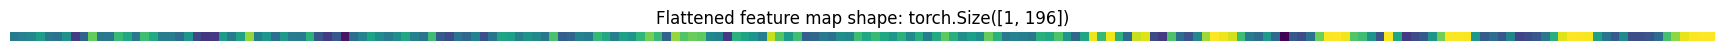

In [47]:
# visualization ignore
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);
single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape # one feature map has 196 elements(tokens to transformer)

In [48]:
#4.5 Turning the ViT patch embedding layer into a PyTorch module
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()

        # Create a layer to turn an image into patches
        self.convolution = nn.Conv2d(in_channels = in_channels, # number of input color channels
                        out_channels = embedding_dim, # from Table 1: Hidden size D, this is the embedding size
                        kernel_size = patch_size, # could also use (patch_size, patch_size)
                        stride = patch_size, 
                        padding = 0)
        
        #  Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, #flatten feature_map_height (dimension 2)
                        end_dim=3) #   flatten feature_map_width (dimension 3)
    
    #forward method uses above defined things
    def forward(self, x):
        # print(x.shape)
        x = self.convolution(x) #returns a tensor which requires grad by default(learnable)
        x = self.flatten(x) #flatten the patch feature maps into a single dimension
        # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
        x = x.permute(0, 2, 1)
        return x

In [49]:
set_seeds() #random initialization of NN weights, for reproducibaility

embed_image = PatchEmbedding(in_channels=3, # Create an instance of patch embedding layer
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")#putting image in batch, otherwise will error
patch_embedded_image = embed_image(image.unsqueeze(0)) # Pass a single image through
print(f"Output patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]") 

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [50]:
# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=(1,3,224,224), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (convolution)                   [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [51]:
#4.6 Creating the class token embedding - to prepend to embeddings list
batch_size = patch_embedded_image.shape[0] # Get the batch size
embedding_dimension = patch_embedded_image.shape[-1] # embedding dimension

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens(only one for class token), embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable, using a simple tensor will not be learnable?

print(class_token[:, :, :10]) # Show the first 10 examples of the class_token
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]") # Print the class_token shape

tensor([[[-2.4663,  0.4867,  0.8128,  0.3298, -1.6121, -0.5759, -0.2281,
           0.2943,  0.1197,  1.5855]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [52]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), # Add the class token embedding to the front of the patch embedding
                                                      dim=1) # concat on first dimension

print(patch_embedded_image_with_class_embedding)
print(f"patch embeddings with class token: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-2.4663,  0.4867,  0.8128,  ...,  0.9203,  0.2370,  1.4758],
         [-0.6962,  0.2186, -0.0727,  ...,  0.3363, -0.4367,  0.2223],
         [-0.6360, -0.0630, -0.0839,  ...,  0.5234, -0.3243, -0.0222],
         ...,
         [-0.0554,  0.0245, -0.1084,  ...,  0.0860, -0.0417,  0.0326],
         [-0.0779,  0.0083, -0.0493,  ...,  0.0643, -0.0233,  0.0152],
         [-0.0779,  0.0116, -0.0477,  ...,  0.0552, -0.0283,  0.0214]]],
       grad_fn=<CatBackward0>)
patch embeddings with class token: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [53]:
# 4.7 Creating the position embedding, randomly initialized, transformer learns later?
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1, #197
                                             embedding_dimension), #768
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-7.4114e-01,  8.1541e-01, -3.6316e-01,  1.0176e+00,  4.5293e-01,
           9.5421e-01, -1.9018e+00,  9.4062e-02, -1.0380e+00,  8.5705e-01],
         [-6.3292e-01,  6.0168e-01,  7.7370e-01, -6.4148e-01, -1.5129e-02,
          -7.0166e-01, -5.5823e-01,  1.1979e+00,  1.0343e+00, -8.0253e-01],
         [ 4.1812e-01, -8.0315e-01,  6.8380e-01, -6.9289e-01, -3.1867e-01,
          -1.1738e+00, -2.0773e+00,  8.2932e-02, -4.8459e-01,  5.6662e-01],
         [ 9.8222e-01, -2.8216e-01, -8.5354e-01,  9.9346e-02,  4.3550e-02,
           2.0549e-01,  1.7851e+00,  5.2269e-02,  2.8783e-01,  1.2212e+00],
         [ 3.9332e-01, -4.4542e-01, -1.1296e+00,  2.9640e-01,  1.2835e+00,
          -4.3154e-01, -3.4652e-01,  3.9845e+00,  1.7684e+00, -2.0047e-01],
         [-1.0939e+00,  6.1262e-01, -6.9854e-02, -2.3281e-01,  8.0949e-04,
           4.6305e-02, -3.4145e-01, -6.8767e-01, -9.8743e-01,  2.3791e+00],
         [-1.5328e+00, -7.9215e-01, -5.5720e-01,  1.0095e+00, -6.4669e-01,
          -1.2823e+

In [54]:
# Add(not concat, see equation) the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"final embedding shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-3.2074,  1.3021,  0.4496,  ...,  2.0919, -0.4471, -0.3826],
         [-1.3291,  0.8202,  0.7010,  ..., -0.0942, -1.6128,  0.7263],
         [-0.2179, -0.8661,  0.5999,  ...,  0.4179,  0.8836, -1.1897],
         ...,
         [-0.2558, -2.7045, -0.5976,  ..., -1.6200,  0.1248,  1.2913],
         [ 0.3558,  0.2111,  0.7218,  ..., -0.1856, -0.7088, -0.0185],
         [-1.8168,  0.7685, -1.0858,  ..., -1.5431, -0.1832,  0.4787]]],
       grad_fn=<AddBackward0>)
final embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [55]:
# 4.8 Putting it all together: from image to embedding
set_seeds() #for reproducibility

patch_size = 16
print(f"Image tensor shape: {image.shape}") 
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0) # 3. Get image tensor and add batch dimension
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3, # 4. Create patch embedding layer
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x) # 5. Pass image through patch embedding layer
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0] # 6. Create class token embedding
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1) # 7. Prepend class token embedding to patch embedding
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2) # 8. Create position embedding, here 196 patches
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

patch_and_position_embedding = patch_embedding_class_token + position_embedding # 9. Add(not concat) position embedding to patch embedding with class token
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [56]:
#designing a MSA block with layer norm
class MultiheadSelfAttentionBlock(nn.Module): #see pytorch docs exmample for more clarity
    #Initialize the class with hyperparameters from Table 1
    def __init__(self, embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0):
        super().__init__()

        #initialize functions with the required params
        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                            num_heads = num_heads,#ac to paper
                            dropout=attn_dropout, #no dropout used
                            batch_first = True) #batch dimension is first dim
        
        #Input: (N,*), Output: (N,*), normalizes across all layers except the first(usually)
        #But If a single integer is used(normalized_shape), it is treated as a singleton list, 
        # and this module will normalize over the last dimension which is expected to be of that specific size.
        self.layer_norm  = nn.LayerNorm(normalized_shape = embedding_dim)
    
    def forward(self, x): #flow of computation
        x = self.layer_norm(x) #outputs same shape - bx197(patches)x768(embed_dim)
        #self attention, so q,k,v are the same values?
        attn_output, _ = self.multihead_attn(query=x, # query embeddings, _ for weights(dont need weights)
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # we dont need weights, just the layer outputs
        return attn_output

In [57]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12, attn_dropout = 0) 
                                                            
# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [58]:
class MLPBlock(nn.Module): #designing a MLPBlock -similar to above, see for clarification
    def __init__(self,  # Initialize the class with hyperparameters from Table 1 and Table 3
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        self.layer_norm  = nn.LayerNorm(normalized_shape = embedding_dim)

        #Input: (*,Hin) where (Hin) means any number of dimensions including none and Hin=in_features.
        #Output: (*,Hout) where all but the last dimension are the same shape as the input and Hout=out_features.
        self.mlp = nn.Sequential(nn.Linear(in_features = embedding_dim, out_features = mlp_size),
                                    nn.GELU(),
                                    nn.Dropout(p=dropout), #p (float) – probability of an element to be zeroed. Default: 0.5
                                    nn.Linear(in_features = mlp_size, out_features = embedding_dim),
                                    nn.Dropout(p=dropout))
        

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [59]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [60]:
# 7.1 Creating a Transformer Encoder by combining our custom made layers
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self, # Initialize the class with hyperparameters from Table 1 and Table 3
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, 
                            num_heads=num_heads, attn_dropout = attn_dropout)
        
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [61]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [62]:
# Create the same as above with torch.nn.TransformerEncoderLayer() LOLOL!! Why :(
# see https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#transformerencoderlayer
#also see fast path in the above link

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768,
                                                             nhead = 12, # for paralled self attention, not layers of the encoder
                                                             dim_feedforward = 3072,
                                                             dropout = 0.1, #for mlp? seems so atleast
                                                             activation = "gelu",
                                                             batch_first = True,
                                                             norm_first = True
                                                             )
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [63]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [64]:
#a tranformer encoder can also be created just using torch, and the preivous torch layer
torch_transformer_encoder = torch.nn.TransformerEncoder(torch_transformer_encoder_layer, 
                                                        num_layers=12, 
                                                        enable_nested_tensor=False)#dunno what this does but to hide warning
torch_transformer_encoder                            

TransformerEncoder(
  (layers): ModuleList(
    (0-11): 12 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [65]:
# # Get the output of PyTorch's version of the Transformer Encoder
summary(model=torch_transformer_encoder,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)  [1, 197, 768]        [1, 197, 768]        --                   True
├─ModuleList (layers)                    --                   --                   --                   True
│    └─TransformerEncoderLayer (0)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─TransformerEncoderLayer (1)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─TransformerEncoderLayer (2)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─TransformerEncoderLayer (3)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─TransformerEncoderLayer (4)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─TransformerEncoderLayer (5)       [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    └─Transfo

In [66]:
class ViT(torch.nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        assert img_size%patch_size == 0, "image_size and patch_size not compatible"
        self.n_patches = (img_size**2)//patch_size**2
        
        #the whole batch is processed together, conv2d does not care, takes batch_size by default
        self.img_patch_embedding = PatchEmbedding(in_channels=in_channels, 
                                                    patch_size=patch_size, 
                                                    embedding_dim = embedding_dim)
        
        #create for one, expand for whole batch later, as every image needs one
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), # [batch_size, number_of_tokens(only one for class token), embedding_dimension]
                                                    requires_grad=True) # make sure the embedding is learnable
        
        #create for one, no need to expand, element wise addition for all elements in the batch
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.n_patches+1, embedding_dim), #1,196+1,768
                                                    requires_grad=True)
        
        self.patch_embedding_droput = nn.Dropout(p=embedding_dropout)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "unpacking operator", used to unpack args from a list into method params, see medium article in bookmarks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    mlp_size=mlp_size,
                                                    mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        #only takes class token as input, batch_sizex1x768, see paper
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim, out_features=num_classes))

    def forward(self,x):
        batch_size = x.shape[0]
        
        x = self.img_patch_embedding(x)

        #  expand for whole batch, as every image needs one
        class_token_embedding = self.class_embedding.expand(batch_size, -1, -1) #-1 means leave that unchanged, same values for each entry in batch
        x = torch.cat((class_token_embedding, x), dim=1)# Add the class token embedding to the front of the patch embedding
        
        # position_embedding = self.position_embedding.expand(batch_size, -1, -1)# no need, automatic element wise addition to each element in batch
        x = x + self.position_embedding #pos encoding
        x = self.patch_embedding_droput(x)

        x = self.transformer_encoder(x)
        #only put first token for every element in the clasifier
        x= self.classifier(x[:,0]) #equivalent to x[:,0,:]

        return x

In [67]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [68]:
#remember this is for one image, in training we will have many which will adjust gradients
set_seeds()
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)
vit = ViT(num_classes=len(class_names)) # Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit(random_image_tensor) # Pass the random image tensor to our ViT instance, ouput is logits of the 3 classes

tensor([[0.5226, 0.1689, 0.4859]], grad_fn=<AddmmBackward0>)

In [69]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(16, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [16, 3, 224, 224]    [16, 3]              152,064              True
├─PatchEmbedding (img_patch_embedding)                       [16, 3, 224, 224]    [16, 196, 768]       --                   True
│    └─Conv2d (convolution)                                  [16, 3, 224, 224]    [16, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [16, 768, 14, 14]    [16, 768, 196]       --                   --
├─Dropout (patch_embedding_droput)                           [16, 197, 768]       [16, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [16, 197, 768]       [16, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [16, 197, 768]       [16, 197, 768]

In [28]:
from modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.003, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]d:\Programs\.conda\envs\fusion360\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
 10%|█         | 1/10 [00:47<07:05, 47.27s/it]

Epoch: 1 | train_loss: 3.0445 | train_acc: 0.4042 | test_loss: 3.7005 | test_acc: 0.3125


 20%|██        | 2/10 [01:31<06:05, 45.75s/it]

Epoch: 2 | train_loss: 1.4071 | train_acc: 0.4042 | test_loss: 1.4453 | test_acc: 0.3125


 30%|███       | 3/10 [02:16<05:16, 45.22s/it]

Epoch: 3 | train_loss: 1.1743 | train_acc: 0.3208 | test_loss: 1.2031 | test_acc: 0.3125


 40%|████      | 4/10 [03:03<04:36, 46.03s/it]

Epoch: 4 | train_loss: 1.1920 | train_acc: 0.2667 | test_loss: 1.2028 | test_acc: 0.2375


 50%|█████     | 5/10 [03:52<03:55, 47.03s/it]

Epoch: 5 | train_loss: 1.1682 | train_acc: 0.3375 | test_loss: 1.1267 | test_acc: 0.3125


 60%|██████    | 6/10 [04:41<03:11, 47.82s/it]

Epoch: 6 | train_loss: 1.1756 | train_acc: 0.3375 | test_loss: 1.1792 | test_acc: 0.2375


 70%|███████   | 7/10 [05:31<02:25, 48.36s/it]

Epoch: 7 | train_loss: 1.2627 | train_acc: 0.2875 | test_loss: 1.1803 | test_acc: 0.2375


 80%|████████  | 8/10 [06:18<01:36, 48.01s/it]

Epoch: 8 | train_loss: 1.2013 | train_acc: 0.3750 | test_loss: 1.2406 | test_acc: 0.3125


 90%|█████████ | 9/10 [07:06<00:47, 47.97s/it]

Epoch: 9 | train_loss: 1.1680 | train_acc: 0.3875 | test_loss: 1.1020 | test_acc: 0.4500


100%|██████████| 10/10 [07:54<00:00, 47.45s/it]

Epoch: 10 | train_loss: 1.2534 | train_acc: 0.2833 | test_loss: 1.2662 | test_acc: 0.2375


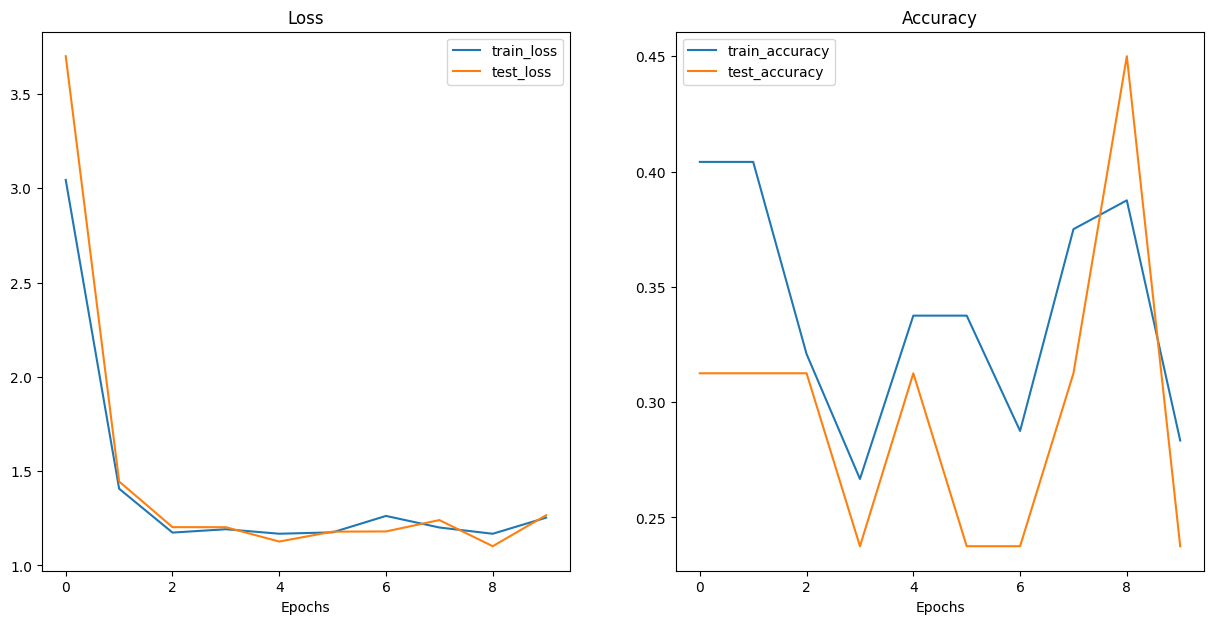

In [70]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [40]:
torch.hub.set_dir("D:\Programs\.conda\\torch\hub")#set so it goes in D: instead of C:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
print(pretrained_vit_weights)
# 2. Setup a ViT model instance with pretrained weights
pretrained_vit_b_16_model = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit_b_16_model.parameters(): #see nn.Module
    parameter.requires_grad = False #torch.nn.parameter.Parameter

#check out heads at the bottom, that we change to get our classifier
print(pretrained_vit_b_16_model) #(head): Linear(in_features=768, out_features=1000, bias=True)

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit_b_16_model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

#now check out heads at the bottom
print(pretrained_vit_b_16_model)   #(heads): Linear(in_features=768, out_features=3, bias=True)

ViT_B_16_Weights.IMAGENET1K_V1
VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwi

In [42]:
# # Print a summary using torchinfo (uncomment for actual output)
#notice that the bottom linear layer was Trainable = False before we replaced it, now it is True
#also now only 2K trainable params comapred to 85M before, can use bigger batch size :)
summary(model=pretrained_vit_b_16_model,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [46]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [47]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,#only this is different
                                                                                                     batch_size=32) # Could increase if we had more samples, 
                                                                                                    #  such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

In [48]:
from modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit_b_16_model.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit_b_16_model,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

 10%|█         | 1/10 [01:02<09:24, 62.70s/it]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665


 20%|██        | 2/10 [01:37<06:12, 46.50s/it]

Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977


 30%|███       | 3/10 [02:12<04:47, 41.09s/it]

Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081


 40%|████      | 4/10 [02:48<03:55, 39.25s/it]

Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081


 50%|█████     | 5/10 [03:25<03:10, 38.10s/it]

Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977


 60%|██████    | 6/10 [04:00<02:28, 37.22s/it]

Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280


 70%|███████   | 7/10 [04:36<01:50, 36.96s/it]

Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883


 80%|████████  | 8/10 [05:13<01:13, 36.69s/it]

Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778


 90%|█████████ | 9/10 [05:49<00:36, 36.65s/it]

Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384


100%|██████████| 10/10 [06:25<00:00, 38.54s/it]

Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


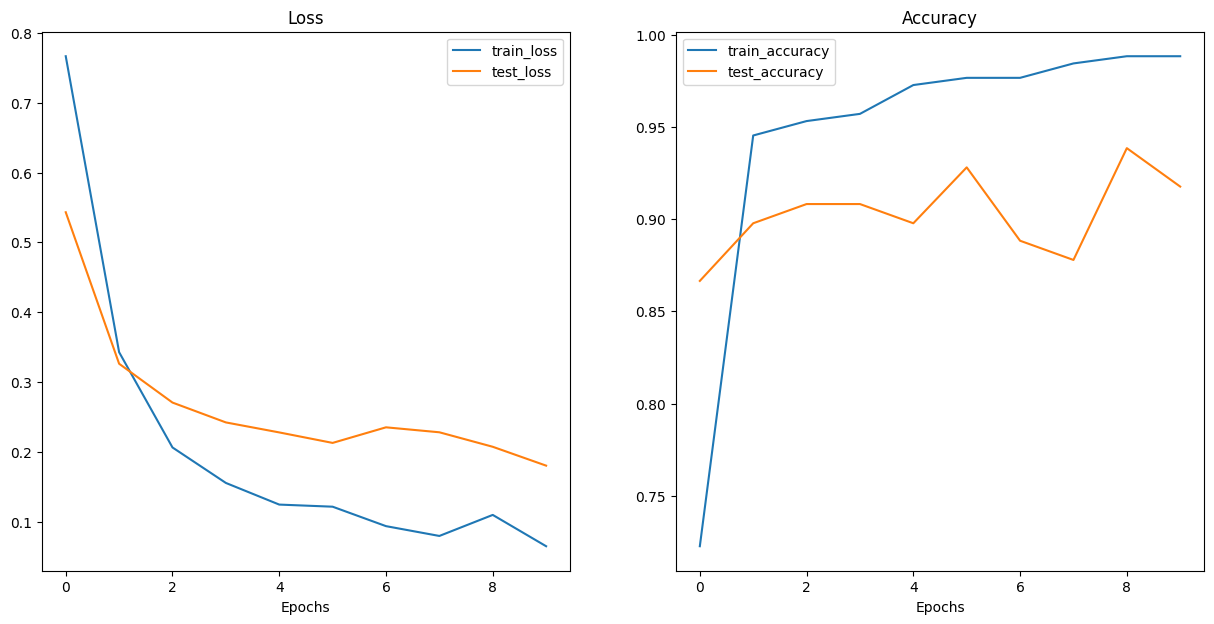

In [49]:
# Plot the loss curves
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_results)

In [52]:
from modular import utils
# Save the model
utils.save_model(model=pretrained_vit_b_16_model,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models\08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [53]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")
#see course ipynb text for comparison and trade-offs comments

Pretrained ViT feature extractor model size: 327 MB


In [54]:
#test pretrained model on a custom image
import requests

# Import function to make predictions on images and plot them
from modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

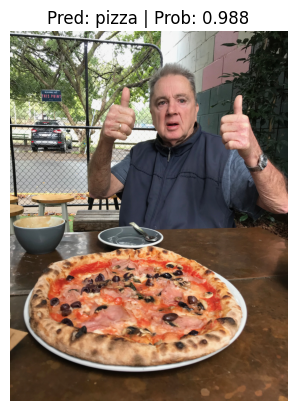

In [55]:
# Predict on custom image
pred_and_plot_image(model=pretrained_vit_b_16_model,
                    image_path=custom_image_path,
                    class_names=class_names)